In [372]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,auc,confusion_matrix,roc_curve

# Index
* [Load and Inspect Data](#Load-and-Inspect-Data)
    * [Handle Age Outliers](#Handle-Age-Outliers)
    * [Exploratory Data Analysis](#EDA) 
* [Data Preprocessing](#Data-Preprocessing)
* [Model Fitting](#Model-Fitting)
* [Model Performance](#Model-Performance)
* [Model Interpretation](#Model-Interpretation)



### Load and Inspect Data 

In [223]:
data = pd.read_csv("conversion_data.csv")

In [224]:
data.head()


,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [225]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [226]:
data.describe(include="all")

,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


There is no missing values.

### Handle Age Outliers 

In [227]:
#Check how many age outliers 
data.loc[data['age']>100,:]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


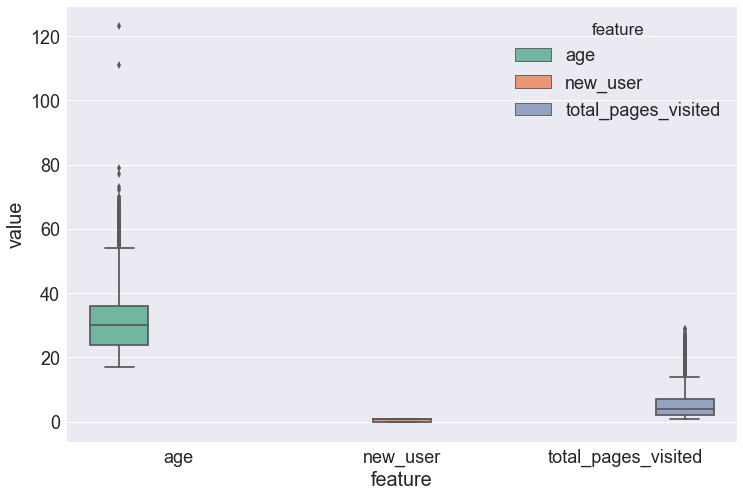

In [228]:
#Visualize the data distribution for quantitative features using boxplot 
sns.set_style("darkgrid")
plt.figure(figsize=(12,8))
d_melted = pd.melt(data[["age","new_user","total_pages_visited"]])
d_melted.columns = ["feature","value"]
sns.boxplot(x="feature", y="value", hue="feature",data=d_melted,palette='Set2')
plt.show()

There are two age outliers; No obvious outliers for "new_user_feature" and "total_pages_visited". I simply remove the age outliers.

In [229]:
data = data.loc[data['age']<100,:]

### EDA

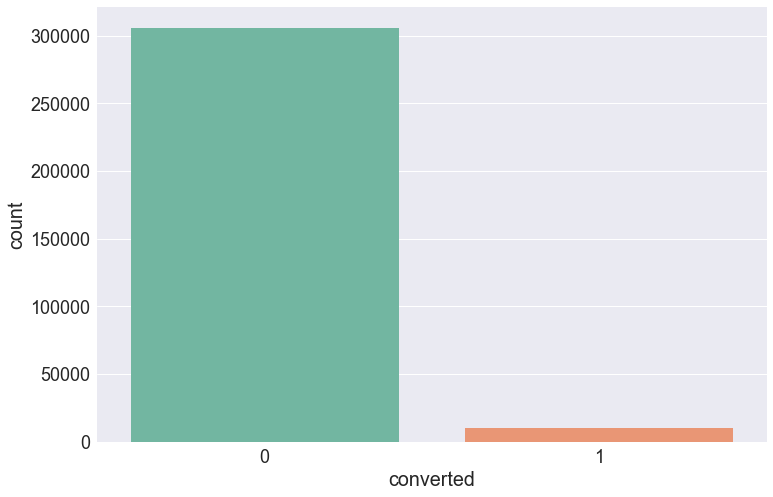

In [230]:
#Check the distribution of results 
sns.set(font_scale=1.8)
plt.figure(figsize=(12,8))
sns.countplot(data['converted'],palette='Set2')
plt.show()

The data is highly imbalanced, with less positive class. I will apply the up sampling later.

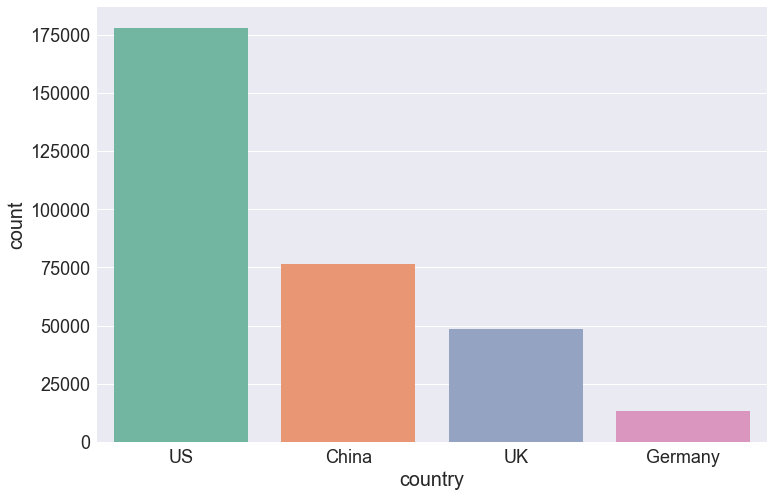

In [231]:
#country distribution 
sns.set(font_scale=1.8)
plt.figure(figsize=(12,8))
country = data['country'].value_counts()
sns.countplot(data['country'],
              palette='Set2',order=list(data["country"].value_counts().index))
plt.show()

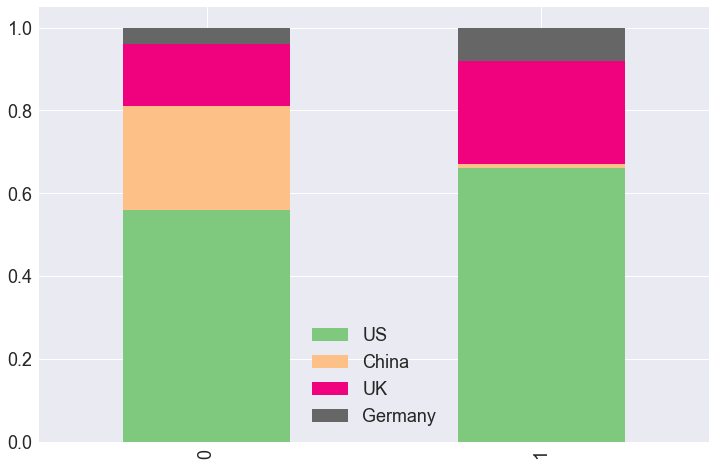

In [232]:
#How is  country distributed in class 1 
plt.figure(figsize=(12,8))
ax1 = plt.subplot(111)
order = list(data["country"].value_counts().index)
count = data['converted'].value_counts()
pos = data.loc[data['converted']==1,"country"].value_counts()[order]/count[1]
neg = data.loc[data['converted']==0,"country"].value_counts()[order]/count[0]
a = pd.concat([pd.DataFrame(neg),pd.DataFrame(pos)],axis=1,ignore_index=True)
a = a.T
a.plot(kind='bar',stacked=True,legend=True,colormap='Accent',ax=ax1)
ax1.legend(loc="best")
ax1.set_xticks([0,1])
plt.show()

The United States is our major users who hit the site. The united states contributes mostly both in class 0 and class 1, while China contribute secondly in class 0 and UK contributes secondly to class 1; the distribution of country in two class is different. Users' nationality may affect the class result.

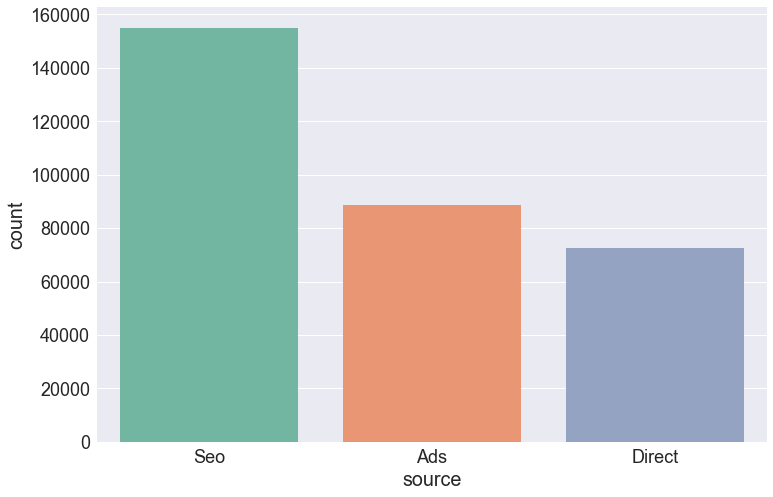

In [233]:
#The distribution of page source 
sns.set(font_scale=1.8)
plt.figure(figsize=(12,8))
sns.countplot(data['source'],
              palette='Set2',order=list(data["source"].value_counts().index))
plt.show()

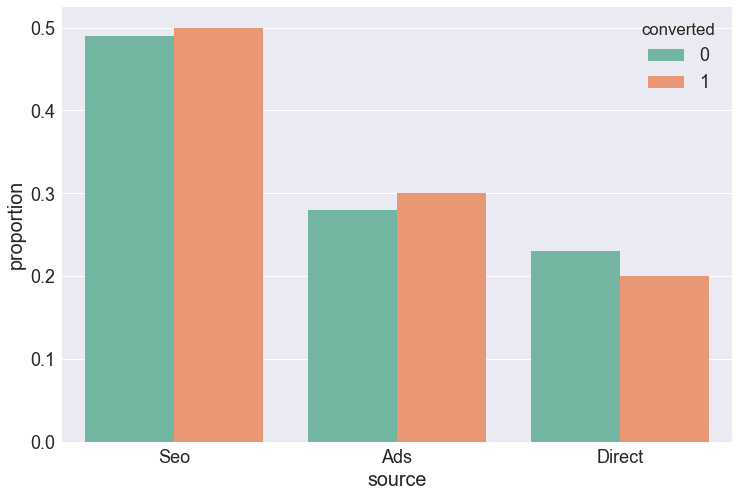

In [234]:
df = data['source'].groupby(data['converted']).value_counts(normalize=True).rename("proportion").reset_index()
plt.figure(figsize=(12,8))
sns.barplot(x="source",y="proportion",hue="converted",data=df,palette='Set2')
plt.show()

"Seo" is the moajor hit source; "Seo" and "Ads" are at higher proportion in class 1 than class 0, while "Direct" is on the contrary.  Adding more Ads about the page may help improve the conversion rate.

/Users/fangqiouyang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


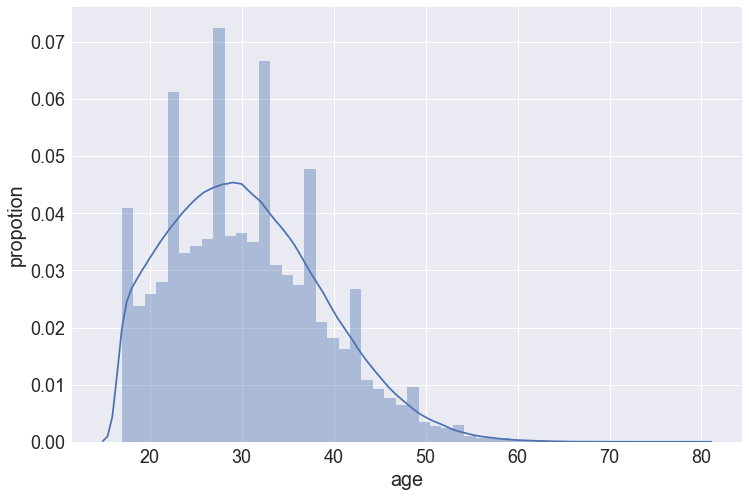

In [235]:
#The distribution of age 
plt.figure(figsize=(12,8))
sns.distplot(data['age'])
plt.ylabel("propotion")
plt.show()

/Users/fangqiouyang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


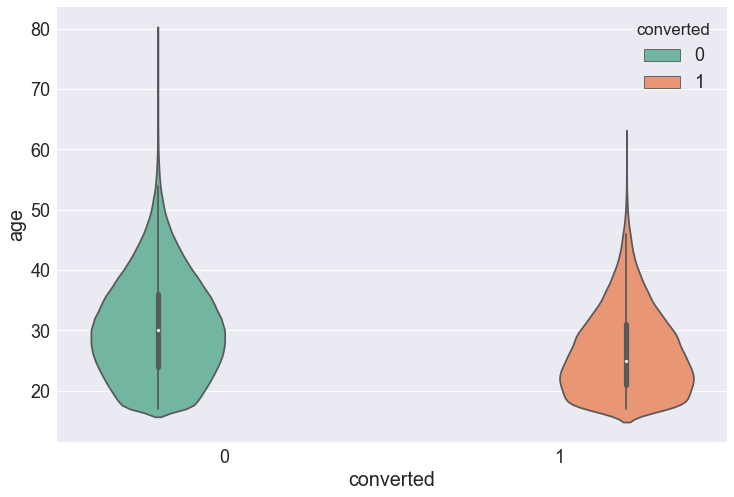

In [236]:
#The viloin plot of age 
plt.figure(figsize=(12,8))
sns.violinplot(x="converted",y="age",hue="converted",data=data,palette='Set2')
plt.show()

Most of our users are in age 20-40; The age of users who bought the product is lower than uses' who didn't buy the porduct. The company should focus more on the young(20-30) when designing the product.

/Users/fangqiouyang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


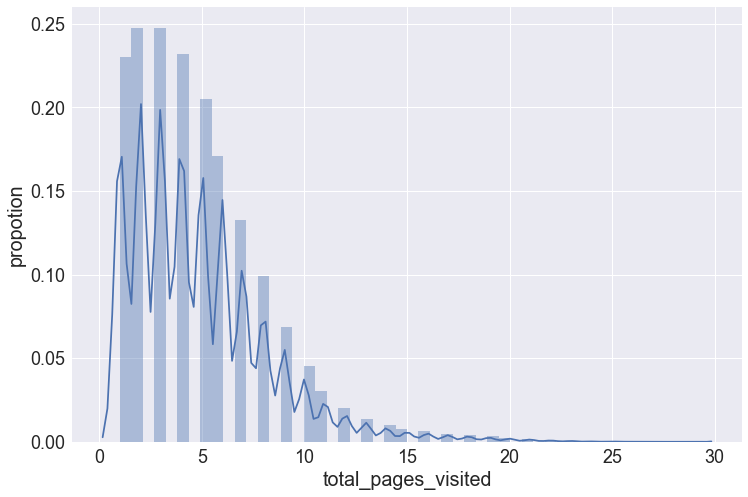

In [237]:
#The distribution of total_pages_visited
plt.figure(figsize=(12,8))
sns.distplot(data['total_pages_visited'])
plt.ylabel("propotion")
plt.show()

/Users/fangqiouyang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


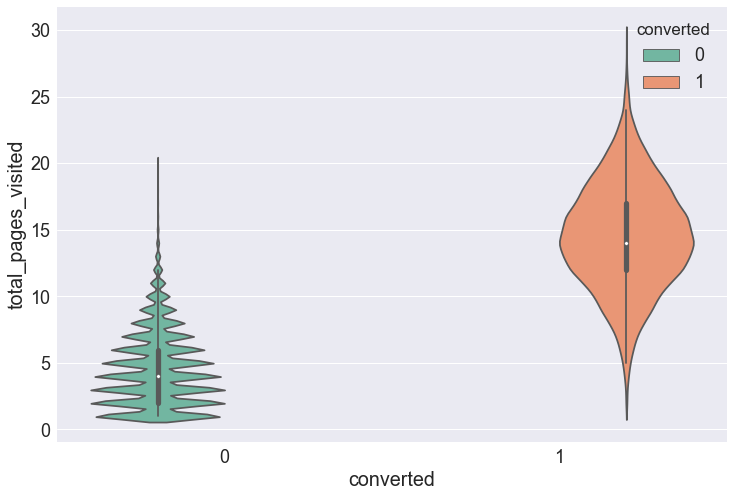

In [238]:
#The viloin plot of age 
plt.figure(figsize=(12,8))
sns.violinplot(x="converted",y="total_pages_visited",hue="converted",data=data,palette='Set2')
plt.show()

Most of the users visited the less than 10 pages; The users who are converted usually visited more pages than those who didn't. "toal_pages_visited" is an important factor that contributs to the conversion.

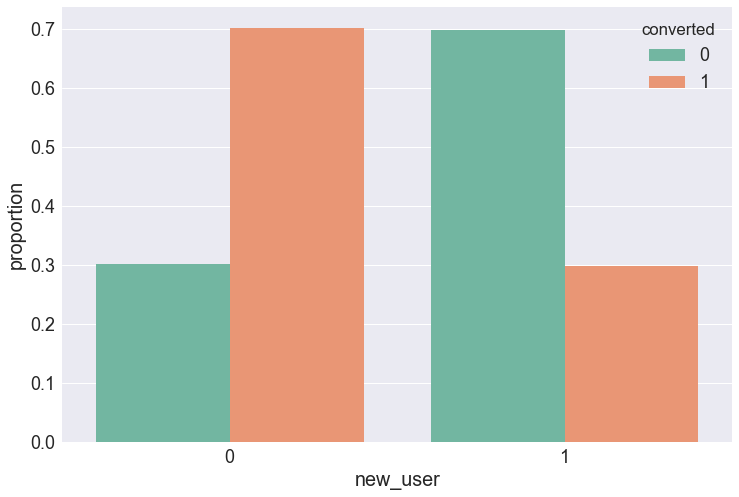

In [239]:
#Whether "new_user" affect the classification result
df = data['new_user'].groupby(data['converted']).value_counts(normalize=True).rename("proportion").reset_index()
plt.figure(figsize=(12,8))
sns.barplot(x="new_user",y="proportion",hue="converted",data=df,palette='Set2')
plt.show()

There are less new users who are converted. Check whether the user is new or not can help predict the possibility of conversion.

### Data Preprocessing 

In [348]:
#Up resampling 
y = data_res["converted"]
data_pos = data.loc[data['converted']==1,:]
indexes = np.random.choice(data_pos.index,count[0]-count[1])
data_res = pd.concat([data,data.loc[indexes,:]])
y = data_res["converted"]

In [349]:
#One-Hot encoding 
d1 = pd.get_dummies(data_res['country'])
d2 = pd.get_dummies(data_res['source'])
data_res.drop(["country","source","converted"],axis=1,inplace=True)
data_res = pd.concat([data_res,d1,d2,pd.DataFrame(y)],axis=1)

In [316]:
#Train Test Split 
X_train,X_test,y_train,y_test = train_test_split(data_res.iloc[:,0:10],data_res.iloc[:,10])

### Model Fitting 

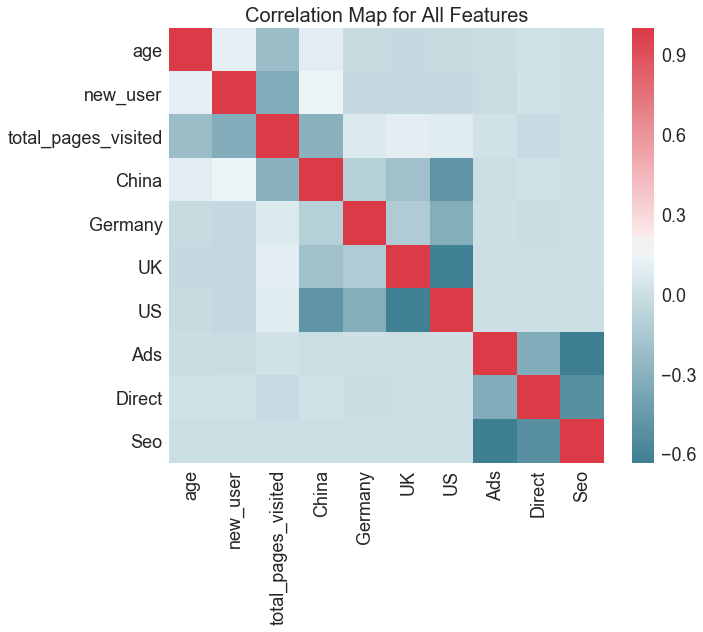

In [353]:
#Logistic regression 
#Check Multi-colinearity 
corr = data_res.iloc[:,0:10].corr()
f, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax)
ax.set_title('Correlation Map for All Features',fontsize=20)
plt.show() 

There is no multi-colinearity, the absolute value of the highest correlation doesn't exceed 0.8. No action is required

In [357]:
#Logistic Regression 
lgcv  = LogisticRegressionCV(Cs=np.logspace(-3,3,7),
                             dual=False,
                             scoring="roc_auc",
                             max_iter=1000,
                             n_jobs=-1,
                             verbose=1
                            )
lgcv.fit(X_train,y_train)

/Users/fangqiouyang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.5s finished


LogisticRegressionCV(Cs=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
           class_weight=None, cv='warn', dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=1000, multi_class='warn',
           n_jobs=-1, penalty='l2', random_state=None, refit=True,
           scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=1)

In [358]:
lgcv.C_ #The best C = 10

array([10.])

### Model Performance 

In [360]:
predictions = lgcv.predict(X_test)
np.mean(predictions==y_test) #Accuracy = 0.94 

0.9396601307189543

In [362]:
#Confusion matirx 
confusion_matrix(y_test,predictions)

array([[71995,  4548],
       [ 4684, 71773]])

In [365]:
#Classification report 
print(classification_report(y_true=y_test,y_pred=predictions))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     76543
           1       0.94      0.94      0.94     76457

   micro avg       0.94      0.94      0.94    153000
   macro avg       0.94      0.94      0.94    153000
weighted avg       0.94      0.94      0.94    153000



/Users/fangqiouyang/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


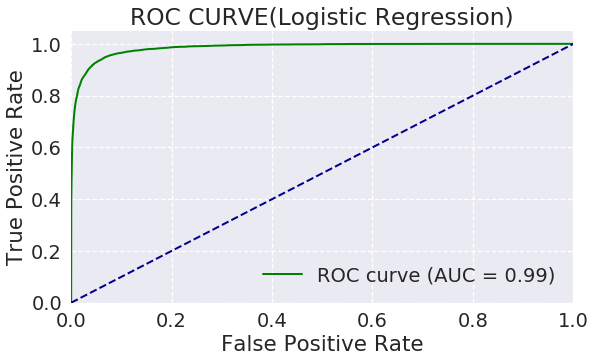

In [374]:
#ROC curve 
prob = lgcv.predict_proba(X_test)
cm = confusion_matrix(y_test,predictions)
tn, fp, fn, tp = cm.ravel()
sns.set('talk', 'darkgrid', 'dark', font_scale=1.5, font='Ricty',
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
fpr, tpr, _ = roc_curve(y_test, prob[:,1])
roc_auc = auc(fpr, tpr)

lw = 2
plt.figure(figsize=(9,5))
plt.plot(fpr, tpr, color='g',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE(Logistic Regression)')
plt.legend(loc="lower right")
plt.show()
plt.savefig('roc_auc.png')
plt.close()

The model gives us auc=0.99, which is nearly perfect.

### Model Interpretation


In [379]:
#feature importance
feat_importances = pd.DataFrame({"name":X_train.columns,"coef":lgcv.coef_[0]})
feat_importances = feat_importances[['name','coef']]# reorder the columns
feat_importances['importances'] = np.abs( feat_importances['coef'] )
feat_importances.sort_values(by="importances",inplace=True,ascending=False)
feat_importances

,name,coef,importances
3,China,-2.752831,2.752831
1,new_user,-1.687461,1.687461
4,Germany,1.136263,1.136263
5,UK,0.937547,0.937547
2,total_pages_visited,0.760517,0.760517
6,US,0.619867,0.619867
8,Direct,-0.107742,0.107742
0,age,-0.071586,0.071586
9,Seo,0.024310,0.024310
7,Ads,0.024280,0.024280


Conlusion :

1. Conversion rate for China is really slow but the number of users in China is ranked as the top 2 right after U.S. Therefore, we can focus more on method for converting the Chinese users, such as add the Chinese translation on the page.
2. Converstion rate for Germany is good given its relatively low number of users. We can put more advertisement on the Germany websites
3. Older people seems less likely to be converted. We could find out the reaon why the old doesn't buy the product and then improve the content of the page.
4. Total_pages_visited is a positive factor. So if the users had visited many pages but didn't buy the product, we should send them the reminder emails.